In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/data1.csv')
print(df.shape)
df.head(df.shape[0])

(100, 3)


,X,Y,LABEL
0,-96,12,1
1,-82,-32,1
2,-98,-91,1
3,-83,45,1
4,-86,-82,1
...,...,...,...
95,81,73,5
96,78,-92,5
97,79,37,5
98,80,-15,5


In [ ]:
# a function for 1-hot encoding the output labels

def normalize(input):
  if input == 1:
    return [1,0,0,0,0]
  elif input == 2:
    return [0,1,0,0,0]
  elif input == 3:
    return [0,0,1,0,0]
  elif input == 4:
    return [0,0,0,1,0]
  elif input == 5:
    return [0,0,0,0,1]

In [ ]:
X1 = df["X"].values.tolist()
X2 = df["Y"].values.tolist()
Y = df["LABEL"].values.tolist()

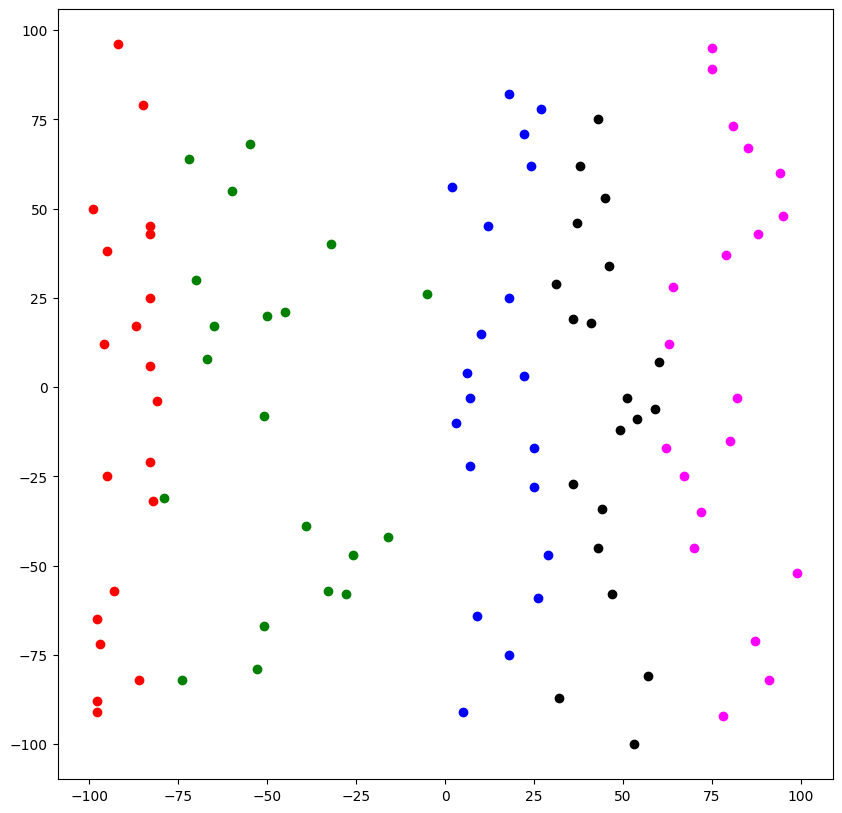

In [ ]:
# plotting all points

plt.figure(figsize=(10,10))
for i in range(len(Y)):
    if Y[i] == 1:
        plt.plot(X1[i], X2[i], c="red", marker="o")
    elif Y[i] == 2:
        plt.plot(X1[i], X2[i], c="green", marker="o")
    elif Y[i] == 3:
        plt.plot(X1[i], X2[i], c="blue", marker="o")
    elif Y[i] == 4:
        plt.plot(X1[i], X2[i], c="black", marker="o")
    elif Y[i] == 5:
        plt.plot(X1[i], X2[i], c="magenta", marker="o")
plt.show()

In [ ]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [ ]:
# normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [ ]:
# dividing the total set into training (80) & testing (20) sets

features_train = features_np[:80]
Y2_train = Y2[:80]

features_test = features_np[80:]
Y2_test = Y2[80:]

In [ ]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons = 2, hidden1LayerNeurons = 20, hidden2LayerNeurons = 20, hidden3LayerNeurons = 20, outLayerNeurons = 5, learning_rate = 0.01, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)

    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]
        pred = self.activation(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.activation(pred, der=True)

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

Epoch: 0, error: 0.3360447562423819
Epoch: 10000, error: 0.07794256618649406
Epoch: 20000, error: 0.07285443422241421
Epoch: 30000, error: 0.0684743238032407
Epoch: 40000, error: 0.06500222656566344
Epoch: 50000, error: 0.06276246101188895
Epoch: 60000, error: 0.061482402555724
Epoch: 70000, error: 0.060800478287584295
Epoch: 80000, error: 0.06050720072490245
Epoch: 90000, error: 0.0588207841705909


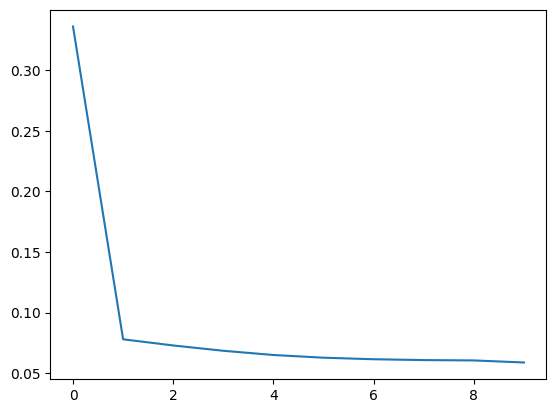

In [ ]:
NN = NeuralNetwork(activation_type = 'sigmoid')

err_list = []

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

In [ ]:
# Use the trained network to make predictions on the test set
predictions = NN.feedForward(features_test)

# Convert predictions to one-hot encoded format
Y_pred = np.argmax(predictions, axis=1)
Y_true = np.argmax(Y2_test, axis=1)

# Calculate the overall accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print(f"Overall Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score for each class
precision = precision_score(Y_true, Y_pred, average=None)
recall = recall_score(Y_true, Y_pred, average=None)
f1 = f1_score(Y_true, Y_pred, average=None)

# Print out the metrics for each class
for i in range(len(precision)):
    print(f"Class {i+1}: Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")

# Calculate and print the macro-average and micro-average metrics
precision_macro = precision_score(Y_true, Y_pred, average='macro')
recall_macro = recall_score(Y_true, Y_pred, average='macro')
f1_macro = f1_score(Y_true, Y_pred, average='macro')

precision_micro = precision_score(Y_true, Y_pred, average='micro')
recall_micro = recall_score(Y_true, Y_pred, average='micro')
f1_micro = f1_score(Y_true, Y_pred, average='micro')

print(f"Macro-average: Precision: {precision_macro}, Recall: {recall_macro}, F1 Score: {f1_macro}")
print(f"Micro-average: Precision: {precision_micro}, Recall: {recall_micro}, F1 Score: {f1_micro}")




Overall Accuracy: 0.55
Class 1: Precision: 0.5714285714285714, Recall: 0.8, F1 Score: 0.6666666666666666
Class 2: Precision: 0.5, Recall: 0.2, F1 Score: 0.28571428571428575
Class 3: Precision: 0.6666666666666666, Recall: 0.6666666666666666, F1 Score: 0.6666666666666666
Class 4: Precision: 1.0, Recall: 0.25, F1 Score: 0.4
Class 5: Precision: 0.42857142857142855, Recall: 1.0, F1 Score: 0.6
Macro-average: Precision: 0.6333333333333333, Recall: 0.5833333333333333, F1 Score: 0.5238095238095238
Micro-average: Precision: 0.55, Recall: 0.55, F1 Score: 0.55


**Documentation:**

**Modification:**

1.Synthetic Dataset with five classes are genarated and outLayerNeurons value updated to 5 having five distinct classes

2.hidden2LayerNeurons and hidden3LayerNeurons are added

3.Added 2 weight matrices to handle the weights between Hidden1-Hidden2 & Hidden2-Hidden3 connections: W_H2H1, W_H3H2.

4.For Forward Propagation calculations , hidden2_input, hidden2_output, hidden3_input, and hidden3_output are added to handle the additional hidden layers in the network.

5.For BackPropagation calculation, hidden3_error, hidden2_error, hidden3_delta, and hidden2_delta are added for the new hidden layers to compute gradients and update weights.

6.Added 3 more activation functions, tanh, reLU & gaussian for testing purposes

7.Biases are added to the neurons in each layer of a neural network to allow the model to fit the data more flexibly.

**Challenges:**

1.Imbalanced datasets can lead to a network that performs well on majority classes but poorly on minority classes, even with three hidden layers.

2.With three hidden layers, the network may overfit the training data, particularly if the model's complexity exceeds the available data size.

**Result and Analysis**

In [ ]:
def conf(Y_true, Y_pred, c = 'magma'):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=c)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def roc_plot(Y2_test, Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Y2_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Y2_test[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #ROC curve for each class
    for i in range(Y2_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
predictions = NN.feedForward(features_test)

Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

Confusion Matrix:
[[4 1 0 0 0]
 [3 1 1 0 0]
 [0 0 2 0 1]
 [0 0 0 1 3]
 [0 0 0 0 3]]


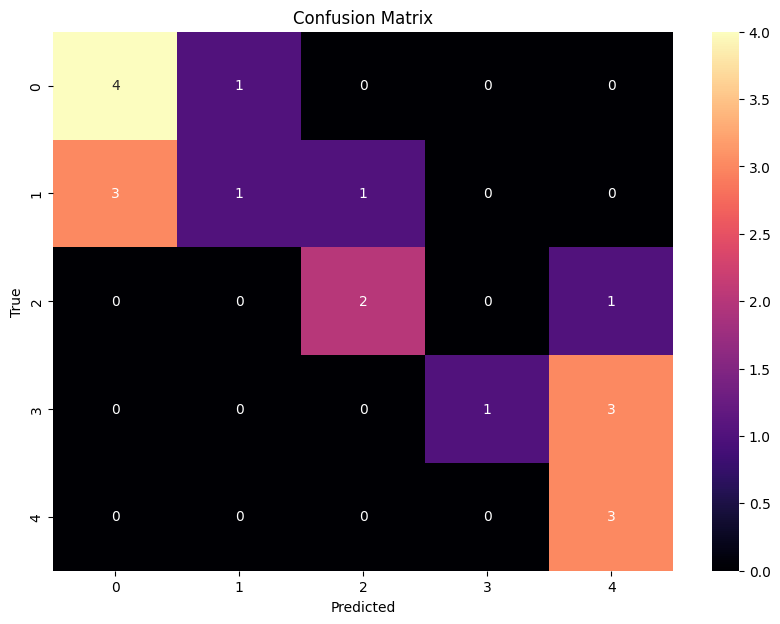

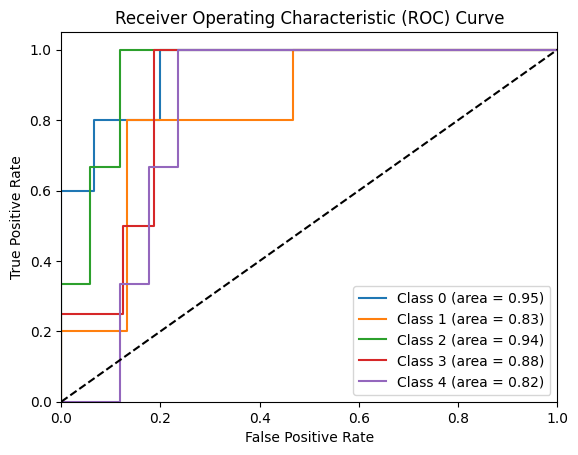

In [ ]:
conf(Y_true, Y_pred)

print()

roc_plot(Y2_test, predictions)

In [ ]:
NN_1 = NeuralNetwork(inputLayerNeurons = 2, hidden1LayerNeurons = 60, hidden2LayerNeurons = 60, hidden3LayerNeurons = 60, outLayerNeurons = 5, learning_rate = 0.001, activation_type= 'sigmoid')

for i in range(100000):
    NN_1.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN_1.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

Epoch: 0, error: 0.5942380980265951
Epoch: 10000, error: 0.08301992885980047
Epoch: 20000, error: 0.0740904795591666
Epoch: 30000, error: 0.06935289707416127
Epoch: 40000, error: 0.06601130869734226
Epoch: 50000, error: 0.06340409188897705
Epoch: 60000, error: 0.0612624906815729
Epoch: 70000, error: 0.05944661946659236
Epoch: 80000, error: 0.05787266019820584
Epoch: 90000, error: 0.05648587207889953


In [ ]:
predictions1 = NN_1.feedForward(features_test)

Y_true1 = np.argmax(Y2_test, axis=1)
Y_pred1 = np.argmax(predictions1, axis=1)

Confusion Matrix:
[[5 0 0 0 0]
 [3 1 1 0 0]
 [0 0 2 0 1]
 [0 0 0 1 3]
 [0 0 1 0 2]]


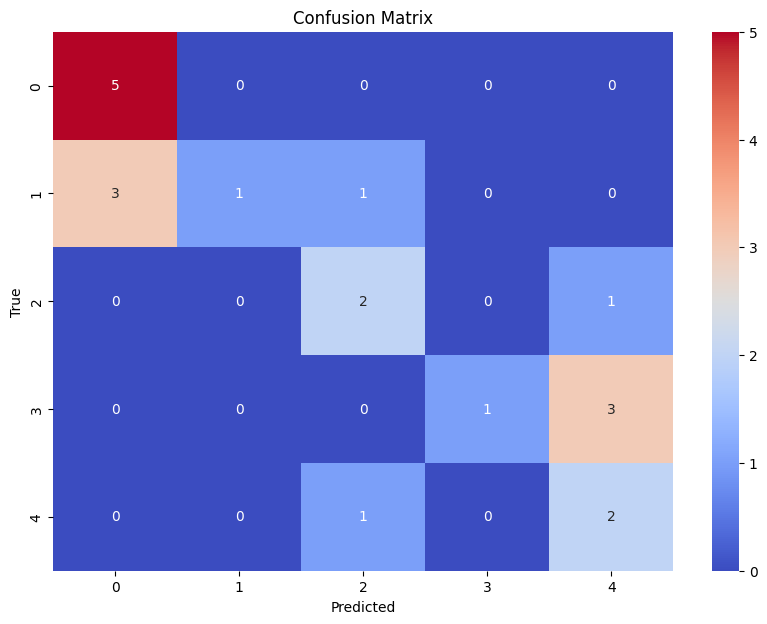

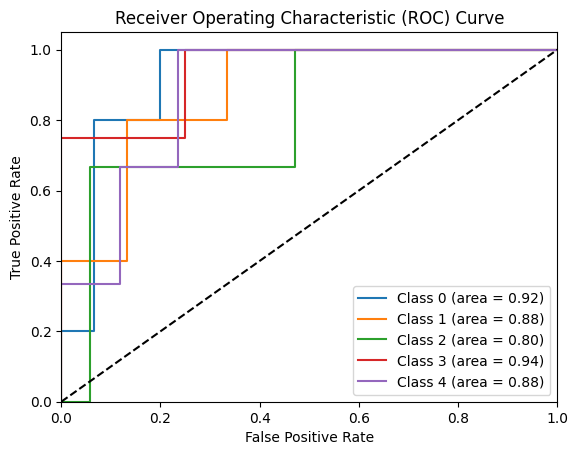

In [ ]:
conf(Y_true1, Y_pred1, 'coolwarm')

print()

roc_plot(Y2_test, predictions1)

In [ ]:
accuracy = accuracy_score(Y_true1, Y_pred1)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true1, Y_pred1, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true1, Y_pred1, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true1, Y_pred1, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.55
Precision for each class:
Class 0: 0.625
Class 1: 1.0
Class 2: 0.5
Class 3: 1.0
Class 4: 0.3333333333333333
Recall: 0.5566666666666666
F1 Score overall: 0.5036874236874237


**Conclusion:**

**Summarize:**
**Key Findings**

**Model Performance:**

The multi-class classification model showed a general trend of decreasing error with increasing epochs, indicating effective learning. For instance, the training error dropped from 0.336 to 0.058 over 90,000 epochs.
Despite the reduction in training error, the overall accuracy remained at 0.55, which indicates that the model might be struggling with certain classes or the dataset might have inherent challenges.

**Class-Specific Metrics:**

Class 1 achieved high precision (0.571) and recall (0.8), resulting in a solid F1 Score of 0.667.

Class 2 had lower performance, with precision (0.5) and recall (0.2) yielding an F1 Score of 0.286.

Class 3 showed balanced performance with a precision and recall both at 0.667, leading to an F1 Score of 0.667.

Class 4 had perfect precision (1.0) but low recall (0.25), resulting in a lower F1 Score of 0.4.

Class 5 exhibited high recall (1.0) but lower precision (0.429), with an F1 Score of 0.6.

The macro-average metrics showed an overall precision of 0.633, recall of 0.583, and F1 Score of 0.524, suggesting mixed performance across classes.

The micro-average metrics reflected the overall accuracy and performance as 0.55 for precision, recall, and F1 Score.

**Error Trends:**

The testing error also decreased over epochs from 0.594 to 0.056, indicating improvement in model generalization. However, the metrics like F1 Score and recall for the overall model showed modest improvement, reflecting the room for enhancement.


**Challenges Encountered and Lessons Learned**

**Class Imbalance:**

The model struggled with classes that had fewer samples or were harder to distinguish. This is evident from the varying precision and recall across different classes.

**Overfitting vs. Underfitting:**

While the training error decreased significantly, the overall accuracy did not improve proportionately, suggesting potential overfitting or insufficient generalization. This was particularly apparent in the lower recall rates for certain classes.

**Model Evaluation:**

It became clear that focusing solely on error reduction is insufficient. Detailed evaluation using precision, recall, and F1 Score provided better insights into the model's performance, especially across different classes.



**Improvement:**
For Hidden Layers,ReLU is generally a good default choice due to its efficiency and effectiveness. For dying ReLU neurons, Leaky ReLU or ELU could be better alternatives.

For Output Layer,Softmax is typically used for multi-class classification tasks, as it provides a probability distribution across classes.
